In [84]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
import seaborn as sns
sns.set(style="darkgrid")

In [85]:
# 一些全局变量 
is_need_log = False
valid_num = 44  #表示第40个月已经预测完毕

In [86]:
sales_data = pd.read_csv("./示例数据/B题-测试数据/order_train2.csv")
test  = pd.read_csv("./示例数据/B题-测试数据/predict_sku2.csv")

In [87]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3


In [88]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677214 entries, 0 to 677213
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         677214 non-null  object 
 1   sales_region_code  677214 non-null  int64  
 2   item_code          677214 non-null  int64  
 3   first_cate_code    677214 non-null  int64  
 4   second_cate_code   677214 non-null  int64  
 5   sales_chan_name    677214 non-null  object 
 6   item_price         677214 non-null  float64
 7   ord_qty            677214 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 41.3+ MB


In [89]:
sales_data.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,677214.000000,677214.000000,677214.000000,677214.000000,677214.000000,677214.000000
mean,102.881955,21002.069281,304.939716,406.446876,1091.399496,89.110023
std,1.490684,591.540499,2.006534,3.084888,1145.879509,197.017004
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20502.000000,303.000000,404.000000,604.000000,10.000000
50%,103.000000,20973.000000,306.000000,407.000000,892.000000,27.000000
75%,105.000000,21507.000000,306.000000,408.000000,1313.000000,96.000000
max,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000


# 1. Data cleaning

## Remove outliers

<AxesSubplot: xlabel='item_price'>

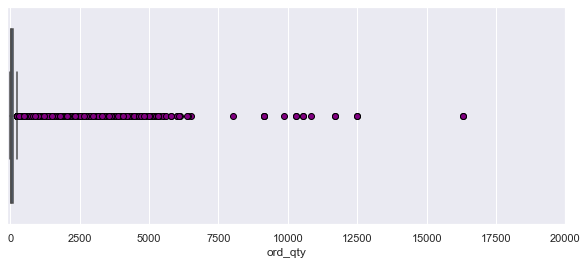

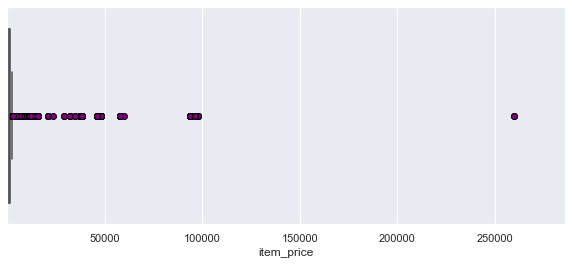

In [90]:
# 销售量
plt.figure(figsize=(10,4))
plt.xlim(-100, 20000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_data.ord_qty, flierprops=flierprops)

# 价格
plt.figure(figsize=(10,4))
plt.xlim(sales_data.item_price.min(), sales_data.item_price.max()*1.1)
sns.boxplot(x=sales_data.item_price, flierprops=flierprops)

In [91]:
sales_data.item_price.max()

260014.0

- 去除销量大于4000的以及价格大于30000的
    - 其实这里还需要验证一下去除的那几条记录，是不是好的，因为可能有些商品就是卖这么多或者怎样
    - 验证一下test集里有没有出现

In [92]:
sales_data = sales_data[(sales_data.item_price < 30000 )& (sales_data.ord_qty < 4000)]

## 数据类型处理

In [93]:
# 时间 object->datetime格式
sales_data["order_date"]=sales_data["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [94]:
# 线上0 线下1
dic = {"offline":1,"online":0}
sales_data['sales_chan_name'] = sales_data['sales_chan_name'].map(dic)

In [95]:
# 单独的item代码，以及其对应的记录条数
train_item = np.unique(sales_data["item_code"],return_counts=True)
train_item

(array([20001, 20002, 20003, ..., 22082, 22083, 22084]),
 array([  13,  779, 2981, ...,  162,  447,  519]))

## 检验这四类code是否一一对应
对后续如何处理很关键

- 简单总结
   - 一级分类和二级分类是一对多的
   - 每个商品只有一个类别，不会对用多种
   - 1421 种商品中，只有 332 种商品是只在一个地区销售的，其他的都在多个地区销售

## 编码label_encoding
- 将地区、item_code、类别进行顺序编码

这里test有train中没有的商品类别（没有更新）
包括
> y contains previously unseen labels: [20011, 20025, 20198, 20273, 20324, 20401, 20449, 20456, 20469, 20503, 20549, 20701, 20721, 20736, 20750, 20793, 20841, 20869, 20951, 20999, 21085, 21184, 21393, 21416, 21523, 21606, 21667, 21687, 21823, 21867, 21879, 21954, 22075]

所以就先不对item code进行编码了

- 标签平滑处理：取对数，其实应该放在不同的时间精度不同，比如按月预测的话，应该先按月合成再取对数
- 按照月份递增的顺序，创建一个包含月份、地区和商品的组合的矩阵df。
    - Item_cnt_day（ord_qty）被求和为Item_cnt_month。
- product()函数也可以用于求取一个可迭代对象中自己各个元素的全排列组合

- 因为每一个月，每个region种所出售的item情况不同，很多时候可能是0（没有这个记录），但是这都要参与到我们的建模中。所以我们要先将所有的情况都列出来。然后再与现有数据合并，缺失的数据就填补为0，这样构建数据集

- ？？？
- 这里暂时按月合成的时候，先忽略线上、线下的因素，全部一股脑合并先，需要补充eda，对不同商品线上线下销售情况进行EDA，再进行分析

In [96]:
# # 销量取对数
# import math
# sales_data["ord_qty"] = list(map(lambda x : x if x== np.NaN else math.log(x+1,2),sales_data["ord_qty"]))

In [97]:
# 生成一列月份编号
sales_data["month"] = sales_data.order_date.dt.month
sales_data["year"] = sales_data.order_date.dt.year
sales_data["date_block_num"] = (sales_data["year"]-sales_data["year"].min())*12+sales_data["month"]-9 # 减8是因为第一个月是9月份

# 输出结果
del sales_data["month"],sales_data["year"]

尝试直接剔除104地区
实际上应该不需要

In [98]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num","sales_region_code", "item_code"]
for i in range(43):
    sales = sales_data[sales_data.date_block_num == i]
    region_list = sales.sales_region_code.unique() # （不）剔除了104地区
    item_list = sales.item_code.unique()
    matrix.append( np.array(list( product( [i],region_list , item_list) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols ) # 堆叠
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["sales_region_code"] = matrix["sales_region_code"].astype(np.int8)
matrix["item_code"] = matrix["item_code"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts 

0.22646808624267578

In [99]:
# add revenue to train df 收入
sales_data["revenue"] = sales_data["item_price"] * sales_data["ord_qty"]

In [100]:
ts = time.time()
group = sales_data.groupby( ["date_block_num", "sales_region_code", "item_code"] ).agg( {"ord_qty": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True) # 这一步重置索引，直接把层级索引转换为列
matrix = pd.merge( matrix, group, on = cols, how = "left" ) # 转换后，二者就可以merge了
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16) # 填补缺失值
time.time() - ts

0.1412806510925293

In [101]:
# matrix就是每月、每个地区、每个商品的销量
matrix.head()  

,date_block_num,sales_region_code,item_code,item_cnt_month
0,0,101,20003,0.0
1,0,101,20006,0.0
2,0,101,20007,3092.0
3,0,101,20008,308.0
4,0,101,20009,260.0


- 为第40个月设置一下test集

In [102]:
# 对测试集添加一个月份列，同时设置一下三列的数据格式

test["date_block_num"] = valid_num+1
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["sales_region_code"] = test.sales_region_code.astype(np.int8)
test["item_code"] = test.item_code.astype(np.int16)

- 合并训练集和测试集

In [103]:
map_cate_df = sales_data[["first_cate_code","second_cate_code","item_code"]].drop_duplicates()
map_cate_df.head()

,first_cate_code,second_cate_code,item_code
0,307,403,22069
1,301,405,20028
2,307,403,21183
3,308,404,20448
4,307,403,21565


In [104]:
# matrix.head()

In [105]:
# 给matrix补充上类别属性
matrix = pd.merge(matrix, map_cate_df, on = ["item_code"], how = "left")
matrix["first_cate_code"] = matrix["first_cate_code"].astype(np.int16)
matrix["second_cate_code"] = matrix["second_cate_code"].astype(np.int16)

In [106]:
# matrix.head()

In [107]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,101,20003,0.0,301,405
1,0,101,20006,0.0,307,403
2,0,101,20007,3092.0,305,412
3,0,101,20008,308.0,303,401
4,0,101,20009,260.0,306,407
...,...,...,...,...,...,...
117331,42,105,22072,4224.0,305,412
117332,42,105,22075,17.0,307,403
117333,42,105,22081,0.0,303,401
117334,42,105,22083,769.0,303,401


In [108]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,101,20003,0.0,301,405
1,0,101,20006,0.0,307,403
2,0,101,20007,3092.0,305,412
3,0,101,20008,308.0,303,401
4,0,101,20009,260.0,306,407
...,...,...,...,...,...,...
117331,42,105,22072,4224.0,305,412
117332,42,105,22075,17.0,307,403
117333,42,105,22081,0.0,303,401
117334,42,105,22083,769.0,303,401


In [109]:
# 合并滚动预测
if valid_num>=43:
    train_buchong = pd.read_csv(f"./提交数据/final_lgbm_submission_{valid_num}_0.csv")
    train_buchong = train_buchong.rename(columns={'item_cnt_month_pred': 'item_cnt_month'})
    matrix = pd.concat([matrix, train_buchong], ignore_index=True, sort=False, keys=cols) # 按三列，添加？


In [110]:
# 合并训练和测试
ts = time.time()
# cols  = ["date_block_num","sales_region_code", "item_code"]

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) # 按三列，添加？
matrix.fillna( 0, inplace = True )
time.time() - ts

0.020741939544677734

In [111]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,101,20003,0.0,301,405
1,0,101,20006,0.0,307,403
2,0,101,20007,3092.0,305,412
3,0,101,20008,308.0,303,401
4,0,101,20009,260.0,306,407
...,...,...,...,...,...,...
123243,45,105,22066,0.0,307,403
123244,45,105,22072,0.0,305,412
123245,45,105,22075,0.0,307,403
123246,45,105,22083,0.0,303,401


取对数，+1是因为销量有可能为0

In [112]:
matrix.to_csv('./中间数据/matrix.csv', index=False)

In [113]:
# # 销量取对数
import math
if is_need_log:
    matrix["item_cnt_month"] = list(map(lambda x : x if x== np.NaN else math.log(x+1,2),matrix["item_cnt_month"]))

#  3. Feature Engineering

## 3.1 Add lag features to matrix df.

In [114]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "sales_region_code","item_code",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "sales_region_code","item_code", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=["date_block_num", "sales_region_code","item_code"], how='left')
    return df

- Add item_cnt_month lag features

In [115]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3,6,12], ["item_cnt_month"] ) # 添加该商店的该商品一个月、两个月、三个月的销量
time.time() - ts

item_cnt_month


0.18705987930297852

- Add the previous month's average item_cnt. 上个月的平均销量

In [116]:
ts = time.time()
# 计算每个月的平均销量（这个月的所有大杂烩）
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

# 在matrix中添加  前一个月的平均销量 作为一个lag feature
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


0.10843205451965332

- Add lag values of item_cnt_month for month / item_id.

In [117]:
ts = time.time()
# 计算每个月该商品的平均销量（这个月的该商品）
group = matrix.groupby(['date_block_num', 'item_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

# 添加 前三个月该商品的平均销量
matrix = pd.merge(matrix, group, on=['date_block_num','item_code'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


0.3053600788116455

- Add lag values for item_cnt_month for every month / region combination.

In [118]:
ts = time.time()
# 计算 该地区的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3,6,12], ["date_region_avg_item_cnt"] )
matrix.drop( ["date_region_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

<ipython-input-118-708d2aaa7c26>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)


date_region_avg_item_cnt


0.32154202461242676

- Add lag values for item_cnt_month for month/region/item.

In [119]:
ts = time.time()
# 计算每月该地区、该商品的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code","item_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code","item_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3,6,12], ["date_region_item_avg_item_cnt"] )
matrix.drop( ["date_region_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

<ipython-input-119-2947a4bf15f4>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)


date_region_item_avg_item_cnt


0.4238560199737549

- Add lag values for item_cnt_month for month/region/item second_cate(subtype).

In [120]:
ts = time.time()
# 计算每月该地区、该子类商品的 销售量
group = matrix.groupby(['date_block_num', 'sales_region_code', 'second_cate_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_region_subtype_avg_item_cnt']
group.reset_index(inplace=True)

# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', 'sales_region_code', 'second_cate_code'], how='left')
matrix.date_region_subtype_avg_item_cnt = matrix['date_region_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_region_subtype_avg_item_cnt'])
matrix.drop(['date_region_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_region_subtype_avg_item_cnt


0.1921708583831787

- 其实还可以补充一个大类商品的销售情况（有需要再说吧）

## 3.2 add price trend feature
* Add average item price on to matix df. 
* Add lag values of item price per month.
* Add delta price values - how current month average pirce relates to global average.

前面算的一直是销量，这里开始添加的特征是价格
虽然要求预测的是销量，但是价格与销量息息相关，也是重要的特征

Price trend features，最后只有一个'delta_price_lag'特征，具体看代码注释

In [121]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_region_avg_item_cnt_lag_1',
       'date_region_avg_item_cnt_lag_2', 'date_region_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_6', 'date_region_avg_item_cnt_lag_12',
       'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_item_avg_item_cnt_lag_6',
       'date_region_item_avg_item_cnt_lag_12',
       'date_region_subtype_avg_item_cnt_lag_1'],
      dtype='object')

In [122]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,date_block_num,revenue
0,2015-09-01,104,22069,307,403,1,1114.0,19,0,21166.0
1,2015-09-01,104,20028,301,405,1,1012.0,12,0,12144.0
2,2015-09-02,104,21183,307,403,0,428.0,109,0,46652.0
3,2015-09-02,104,20448,308,404,0,962.0,3,0,2886.0
4,2015-09-02,104,21565,307,403,1,1400.0,3,0,4200.0


In [123]:
ts = time.time()
# 添加该商品的平均价格
group = sales_data.groupby( ["item_code"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)



# 添加该商品每月的平均价格，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] ) # 添加价格
for i in lags: # 添加价格趋势
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_price_lag
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


1.5474319458007812

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

我们已经知道validation set和test set都会出现train set所没有的新商品，借助商店revenue趋势特征可以帮助算法预测新商品在现有店铺的销量

该商店的特征同上，但是泰迪杯没有这样的商店列，所以可以用大类或者小类的商品销售趋势替代
暂时用的是细类，其实可以优化为细类和地区的组合

In [124]:
ts = time.time()
group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"revenue": ["sum"] })
group.columns = ["date_subtype_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "second_cate_code"], how = "left" )
matrix['date_subtype_revenue'] = matrix['date_subtype_revenue'].astype(np.float32)

group = group.groupby(["second_cate_code"]).agg({ "date_block_num":["mean"] })
group.columns = ["subtype_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
matrix["subtype_avg_revenue"] = matrix.subtype_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_subtype_revenue'] - matrix['subtype_avg_revenue']) / matrix['subtype_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_subtype_revenue", "subtype_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


0.26195597648620605

- 添加一些线上线下特征
- 添加一些销量趋势特征
- 尝试对商品进行聚类
   - 做一些这一类都有的特征
   - 或者按类建模预测

In [125]:
# sales_data

In [126]:
ts = time.time()
# 添加该商品的平均销量
# 以下为了避免重复，使用了date_item_avg_item_cnt_，最后多加了一个_
group = sales_data.groupby( ["item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_cnt"] = matrix.item_avg_item_cnt.astype(np.float16)



# 添加该商品每月的平均销量，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["date_item_avg_item_cnt_"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_cnt_"] = matrix.date_item_avg_item_cnt_.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_cnt_"] ) # 添加销量
for i in lags: # 添加销量趋势
    matrix["delta_cnt_lag_" + str(i) ] = (matrix["date_item_avg_item_cnt__lag_" + str(i)]- matrix["item_avg_item_cnt"] )/ matrix["item_avg_item_cnt"]
# 注意这里有两个__,为了不与别的特征名字重复
    
def select_trends(row) :
    for i in lags:
        if row["delta_cnt_lag_" + str(i)]:
            return row["delta_cnt_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_cnt_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_cnt_lag"] = matrix.delta_cnt_lag.astype( np.float16 )
matrix["delta_cnt_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_cnt_lag
features_to_drop = ["item_avg_item_cnt", "date_item_avg_item_cnt_"]
for i in lags:
    features_to_drop.append("date_item_avg_item_cnt__lag_" + str(i) )
    features_to_drop.append("delta_cnt_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_cnt_


1.5469000339508057

In [127]:
# 尝试添加一下一年前同月的销量特征
ts = time.time()
# 添加该商品的平均销量
# 以下为了避免重复，使用了date_item_avg_item_cnt_，最后多加了一个_
group = sales_data.groupby( ["item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_cnt"] = matrix.item_avg_item_cnt.astype(np.float16)



# 添加该商品每月的平均销量，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg({"ord_qty": ["mean"]})
group.columns = ["date_item_avg_item_cnt_"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_cnt_"] = matrix.date_item_avg_item_cnt_.astype(np.float16)
lags = [11, 12, 13]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_cnt_"] ) # 添加销量
for i in lags: # 添加销量趋势
    matrix["delta_cnt_lag_" + str(i) ] = (matrix["date_item_avg_item_cnt__lag_" + str(i)]- matrix["item_avg_item_cnt"] )/ matrix["item_avg_item_cnt"]
# 注意这里有两个__,为了不与别的特征名字重复
    
def select_trends(row) :
    for i in lags:
        if row["delta_cnt_lag_" + str(i)]:
            return row["delta_cnt_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_cnt_lag__12"] = matrix.apply(select_trends, axis = 1)
matrix["delta_cnt_lag__12"] = matrix.delta_cnt_lag__12.astype( np.float16 )
matrix["delta_cnt_lag__12"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_cnt_lag__12
features_to_drop = ["item_avg_item_cnt", "date_item_avg_item_cnt_"]
for i in lags:
    features_to_drop.append("date_item_avg_item_cnt__lag_" + str(i) )
    features_to_drop.append("delta_cnt_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_cnt_


1.589341163635254

- 添加线上线下特征

In [128]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_region_avg_item_cnt_lag_1',
       'date_region_avg_item_cnt_lag_2', 'date_region_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_6', 'date_region_avg_item_cnt_lag_12',
       'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_item_avg_item_cnt_lag_6',
       'date_region_item_avg_item_cnt_lag_12',
       'date_region_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'delta_cnt_lag', 'd

- Add month and number of days in each month to matrix df.

添加月份、和该月有多少天的两个特征

In [129]:
matrix["month"] = (matrix["date_block_num"]+9) % 12 # 9个月开始
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

'item_subtype_last_sale'和'item_subtype_sale'用以纪录距离最近一次销售之间隔了几个月，通过它可以和之前月份的数据建立关联。'item_subtype_first_sale'和'item_first_sale'则是用于表示新商品的特征

该商品从第一个销售到现在有几个月了

In [130]:
ts = time.time()
matrix["item_subtype_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code","second_cate_code"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code"])["date_block_num"].transform('min')
time.time() - ts

0.017416000366210938

- 1月、6月、10月标记为促销月


In [131]:
matrix['is_promotion_month'] = ((matrix['month'] % 12 == 1) | (matrix['month'] % 12 == 6) | (matrix['month'] % 12 == 11)).astype(int)


- 线上线下特征

Delete first three months from matrix. They don't have lag values.

In [132]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 12]
time.time() - ts

0.031662940979003906

In [133]:
matrix = matrix.drop_duplicates()

In [134]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,...,date_region_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,delta_cnt_lag,delta_cnt_lag__12,month,days,item_subtype_first_sale,item_first_sale,is_promotion_month
33840,13,101,20003,0.0,301,405,0.000000,0.0,0.0,0.0,...,0.00,-0.071411,1.419666e+06,-0.006149,-0.199585,10,30,13,13,0
33841,13,101,20005,5.0,306,407,0.000000,0.0,0.0,0.0,...,404.50,0.041565,1.264956e+07,-0.390869,-0.187988,10,30,12,12,0
33842,13,101,20006,0.0,307,403,0.000000,0.0,0.0,0.0,...,0.00,-0.024017,1.994304e+06,0.055695,1.519531,10,30,13,13,0
33843,13,101,20008,338.0,303,401,127.000000,219.0,89.0,46.0,...,281.00,-0.037445,4.716996e+06,-0.205444,0.080444,10,30,13,13,0
33844,13,101,20009,9.0,306,407,30.000000,10.0,2.0,18.0,...,404.50,-0.075928,1.264956e+07,-0.795898,-0.291748,10,30,13,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123243,45,105,22066,0.0,307,403,2594.629787,NaN,4624.0,7600.0,...,530.50,0.000000,NaN,0.000000,-0.541992,6,31,29,29,1
123244,45,105,22072,0.0,305,412,1841.096182,NaN,4224.0,1010.0,...,346.50,0.000000,NaN,0.000000,0.000000,6,31,9,9,1
123245,45,105,22075,0.0,307,403,41.657793,NaN,17.0,NaN,...,530.50,0.000000,NaN,0.000000,0.000000,6,31,4,4,1
123246,45,105,22083,0.0,303,401,1836.745742,NaN,769.0,1401.0,...,269.25,0.000000,NaN,0.000000,0.709961,6,31,11,11,1


In [135]:
matrix.to_csv(f"./中间数据/月度数据无编码_12_{valid_num+1}.csv",index=False)